## The last.fm dataset

This dataset contains the following features:
- **user**: The ID of the user
- **artist**: The artist the user has listened to
- **Sex**: The sex of the listening user
- **Country**: The country of residence of the user


This notebook is going to perform exploratory data analysis on the dataset, to create a model which is capable of giving new users recommendations for other artists to explore.

The analysis will mostly look into the listening habits of each user and try to cluster listening habits. We will ignore countries for the time being

## Future possible improvements
- Add more data from possibly 
    - https://www.upf.edu/web/mtg/lastfm360k
    -   

# Dataset loading

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from apyori import apriori

import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
data = pd.read_csv("../data/lastfm.csv")

In [3]:
df = data.copy()
df.isna().sum()

user       0
artist     0
sex        0
country    0
dtype: int64

In [4]:
df.dtypes

user        int64
artist     object
sex        object
country    object
dtype: object

As we can see there are no missing values

## Exploratory data analysis
To get an  quick overview of the data and which parts needs to be looked at, pandas profiling will be used

In [5]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Insights
- We have duplicate rows. These can be deleted, since the dataset only shows which artist a user likes, hence a duplicate tells us nothing
- High cardinality of columns, hence it is possible to cluster this dataset

### Manual exploration

#### Most popular artists

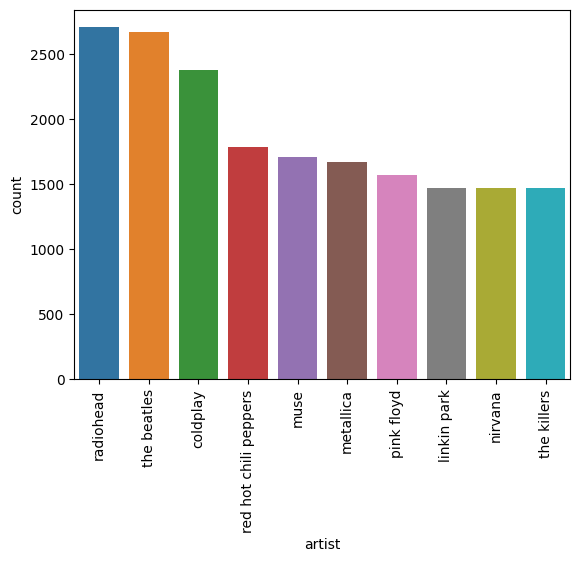

In [6]:
count_df = df.groupby(["artist"])["artist"] \
                    .size() \
                    .reset_index(name='count') \
                    .sort_values(['count'], ascending=False) 
sns.barplot(data=count_df.head(10), x='artist', y="count")
plt.xticks(rotation=90)
plt.show()

## Data manipulation
Now we adjust the data to work with our model

In [7]:
## Drop duplicates
df = df.drop_duplicates()

In [8]:
## Select the columns the clustering will focus on
df = df[['user', 'artist']]

In [9]:
transactions = []
for i in df['user'].unique():
    transactions.append(list(df[df['user'] == i]['artist'].values))

In [10]:
transactions

[['red hot chili peppers',
  'the black dahlia murder',
  'goldfrapp',
  'dropkick murphys',
  'le tigre',
  'schandmaul',
  'edguy',
  'jack johnson',
  'eluveitie',
  'the killers',
  'judas priest',
  'rob zombie',
  'john mayer',
  'the who',
  'guano apes',
  'the rolling stones'],
 ['devendra banhart',
  'boards of canada',
  'cocorosie',
  'aphex twin',
  'animal collective',
  'atmosphere',
  'joanna newsom',
  'air',
  'portishead',
  'massive attack',
  'broken social scene',
  'arcade fire',
  'plaid',
  'prefuse 73',
  'm83',
  'the flashbulb',
  'pavement',
  'goldfrapp',
  'amon tobin',
  'sage francis',
  'four tet',
  'max richter',
  'autechre',
  'radiohead',
  'neutral milk hotel',
  'beastie boys',
  'aesop rock',
  'mf doom',
  'the books'],
 ['tv on the radio',
  'tool',
  'kyuss',
  'dj shadow',
  'air',
  'a tribe called quest',
  'the cinematic orchestra',
  'beck',
  'bon iver',
  'röyksopp',
  'bonobo',
  'the decemberists',
  'snow patrol',
  'battles',
  't

# Clustering using the Apriori algorithm
This implemenatation is loosley based on: https://towardsdatascience.com/the-apriori-algorithm-5da3db9aea95

We will use the Apriori algorithm since it is very good at finding combinations of products that are often bought together (Frequent itemsets)

### Small explanation of the different values in the output of the APriori model
- **Support**: Measures the number of times a particular item or combination of items occur in a dataset
- **Confidence**: Measures how the consumer is likely to like Right_hand_suiden given they like Left_hand_side
- **Lift**: A metric that determines the strength of assocaiation between the best rule 


We will base our recommendations on **Lift**

In [11]:
rules = apriori(transactions = transactions, min_support = 0.01, min_confidence = 0.2, min_lift = 3, min_length = 2)
results = list(rules)

In [12]:
# For visualisation in pandas dataframe
def inspect(output):
    lhs         = [tuple(result[2][0][0])[0] for result in output]
    rhs         = [tuple(result[2][0][1])[0] for result in output]
    support    = [result[1] for result in output]
    confidence = [result[2][0][2] for result in output]
    lift       = [result[2][0][3] for result in output]
    return list(zip(lhs, rhs, support, confidence, lift))
output_DataFrame = pd.DataFrame(inspect(results), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])

output_DataFrame

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
0,3 doors down,linkin park,0.011067,0.357759,3.643163
1,30 seconds to mars,linkin park,0.012533,0.382114,3.891179
2,a perfect circle,nine inch nails,0.010333,0.281307,4.232298
3,a perfect circle,tool,0.016267,0.442831,8.717150
4,aerosmith,ac/dc,0.011000,0.325444,5.300387
...,...,...,...,...,...
329,the rolling stones,the beatles,0.010600,0.563830,3.169958
330,the shins,the beatles,0.010667,0.215924,3.710042
331,the beatles,radiohead,0.011467,0.620939,3.444556
332,the beatles,radiohead,0.010467,0.560714,3.110471


In [13]:
## Show the associations with the highest lift
out = output_DataFrame.sort_values(by="Lift", ascending=False)
out

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
177,jay-z,nas,0.010600,0.349451,14.052971
263,rihanna,the pussycat dolls,0.010400,0.241486,13.415893
53,beyoncé,rihanna,0.013933,0.468610,10.881034
191,katy perry,lady gaga,0.010200,0.335526,9.926814
239,morrissey,the smiths,0.011267,0.465565,8.896141
...,...,...,...,...,...
321,nirvana,muse,0.010533,0.344978,3.024356
80,the doors,bob dylan,0.012067,0.209491,3.021501
107,pixies,david bowie,0.011067,0.222222,3.016591
325,the beatles,nirvana,0.010000,0.295276,3.006880


## Test scenario

In [14]:
out.loc[out["Left_Hand_Side"] == "muse"]

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
285,muse,the killers,0.011067,0.463687,4.721865
322,muse,placebo,0.013667,0.317829,4.102790
240,muse,placebo,0.028067,0.246055,3.176269
324,muse,the killers,0.012800,0.297674,3.031308
